In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
##from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

c:\users\pc\appdata\local\programs\python\python39\lib\site-packages\keras\backend.py:400: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [2]:
X_orig = np.load("X.npy")
Y_orig = np.load("Y.npy")

In [3]:
X_orig = X_orig.reshape(-1,64,64,1)

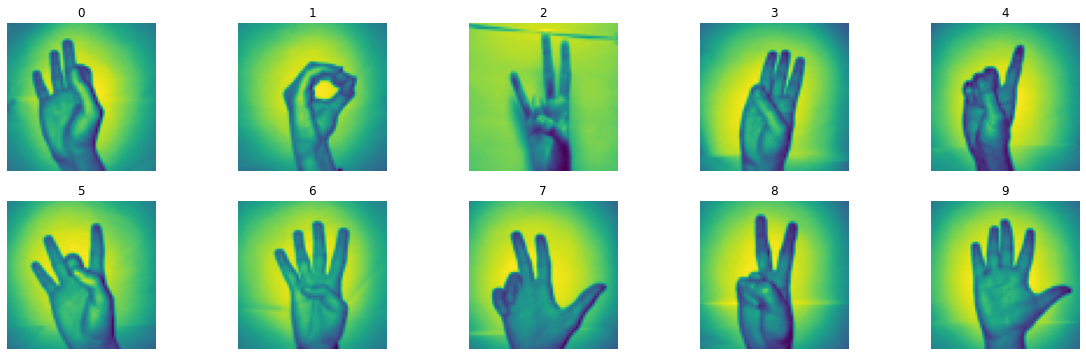

In [4]:
plt.figure(figsize=(20,6))

for i,j in enumerate([0,205,411,617,823,1030,1237,1444,1650,1858]):
    plt.subplot(2,5,i+1)
    plt.imshow(X_orig[j].reshape(64,64))
    plt.title(np.argmax(Y_orig[j]))
    plt.axis("off")

In [5]:
label_y = []

label_y = [np.where(i==1)[0][0] for i in Y_orig]
count = pd.Series(label_y).value_counts()
print(count)

5    208
6    207
3    207
9    207
2    206
4    206
8    206
7    206
1    205
0    204
dtype: int64


In [6]:
X_organized = np.concatenate((X_orig[204:409,:],
                              X_orig[822:1028,:],
                              X_orig[1649:1855,:],
                              X_orig[1443:1649,:],
                              X_orig[1236:1443,:],
                              X_orig[1855:2062,:],
                              X_orig[615:822,:],
                              X_orig[409:615,:],
                              X_orig[1028:1236,:],
                              X_orig[0:204,:]),axis = 0)

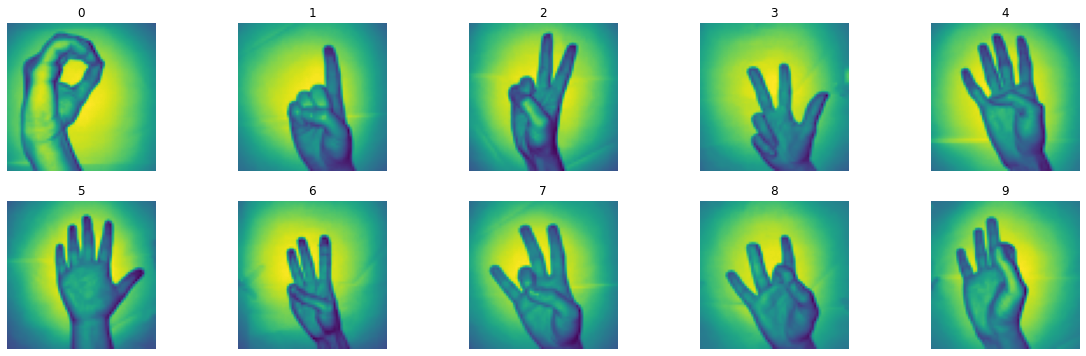

In [7]:
plt.figure(figsize=(20,6))

for i,j in enumerate([0,205,411,617,823,1030,1237,1444,1650,1858]):
    plt.subplot(2,5,i+1)
    plt.imshow(X_organized[j].reshape(64,64))
    plt.title(np.argmax(Y_orig[j]))
    plt.axis("off")

In [8]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(X_organized,Y_orig,test_size=0.2)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1649, 64, 64, 1)
(1649, 10)
(413, 64, 64, 1)
(413, 10)


In [9]:
def ResNet50(input_shape = (64, 64, 1), classes = 10):
    """
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model
    """
    
    # Define the input with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(filters= 64, kernel_size=(3,3), strides=(2,2),padding='valid', use_bias = False, kernel_initializer='he_normal')(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # Stage 2
    X = Conv2D(filters= 128, kernel_size=(3,3), strides=(2,2),padding='valid', use_bias = False, kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)    
    
    stage_2_short_cut = X
    X = Conv2D(filters= 128, kernel_size=(3,3), strides=(1,1),padding='same', use_bias = False, kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters= 128, kernel_size=(3,3), strides=(1,1),padding='same', use_bias = False, kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)
    X = Add()([X, stage_2_short_cut])
    #stage 3
    X = Conv2D(filters= 256, kernel_size=(3,3), strides=(2,2),padding='valid', use_bias = False, kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)      
    
    stage_3_short_cut = X
    X = Conv2D(filters= 256, kernel_size=(3,3), strides=(1,1),padding='same', use_bias = False, kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters= 256, kernel_size=(3,3), strides=(1,1),padding='same', use_bias = False, kernel_initializer='he_normal')(X)
    X = Activation('relu')(X)
    X = Add()([X, stage_3_short_cut])
    #stage 4
    X = AveragePooling2D((3, 3), strides=(2, 2))(X)
    #X = Conv2D(filters= 512, kernel_size=(3,3), strides=(1,1),padding='valid', use_bias = False, kernel_initializer='he_normal')(X)
    #X = Activation('relu')(X)    
    
    #stage_4_short_cut = X
    #X = Conv2D(filters= 512, kernel_size=(3,3), strides=(1,1),padding='same', use_bias = False, kernel_initializer='he_normal')(X)
    #X = Activation('relu')(X)
    #X = Conv2D(filters= 512, kernel_size=(3,3), strides=(1,1),padding='same', use_bias = False, kernel_initializer='he_normal')(X)
    #X = Activation('relu')(X)
    #X = Add()([X, stage_4_short_cut])
  
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax',kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [10]:
model = ResNet50(input_shape=(64,64,1),classes=10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 64)   576         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 31, 31, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 15, 15, 64)   0           activation[0][0]                 
___________________________________________________________________________________________

In [11]:
#Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(train_x, train_y, epochs = 20, batch_size = 32)

Epoch 1/20
52/52 [==============================] - 16s 101ms/step - loss: 3.1485 - accuracy: 0.0863
Epoch 2/20
52/52 [==============================] - 5s 99ms/step - loss: 2.2997 - accuracy: 0.1116
Epoch 3/20
52/52 [==============================] - 6s 107ms/step - loss: 2.1745 - accuracy: 0.1796
Epoch 4/20
52/52 [==============================] - 6s 109ms/step - loss: 1.4340 - accuracy: 0.4670
Epoch 5/20
52/52 [==============================] - 6s 119ms/step - loss: 0.6359 - accuracy: 0.7895
Epoch 6/20
52/52 [==============================] - 6s 113ms/step - loss: 0.4307 - accuracy: 0.86110s - loss: 0.4365 
Epoch 7/20
52/52 [==============================] - 6s 108ms/step - loss: 0.2459 - accuracy: 0.9371
Epoch 8/20
52/52 [==============================] - 5s 103ms/step - loss: 0.1608 - accuracy: 0.9602
Epoch 9/20
52/52 [==============================] - 6s 112ms/step - loss: 0.1407 - accuracy: 0.9602
Epoch 10/20
52/52 [==============================] - 5s 97ms/step - loss: 0.1178 -

In [23]:
evals = model.evaluate(test_x,test_y)
print("loss" +str(evals[0]))
print("accuracy" +str(evals[1]))

13/13 [==============================] - 1s 12ms/step - loss: 0.4322 - accuracy: 0.9249
loss0.4321891963481903
accuracy0.9249394536018372


In [13]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 64)   576         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 31, 31, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 15, 15, 64)   0           activation[0][0]                 
___________________________________________________________________________________________

In [14]:
model.save("my_model")

c:\users\pc\appdata\local\programs\python\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: my_model\assets


In [27]:
from cv2 import cv2
from numpy import asarray
img = cv2.imread("5.jpg")
img = cv2.resize (img, (64,64))
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.imwrite("gray.jpg",img)
img = np.array(img).reshape((1,64,64,1))

In [28]:
model.predict(img)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)